# Intro

This notebook can be used to simulate the route of an UAV using the Markov chain method. The user can input a list of regions and specify the starting and ending region. The simulator will then generate a transition matrix that describes the probability of the UAV selecting the next region based on its current region. Using this transition matrix, the simulator will calculate possible routes from the starting point to the ending point using the Markov chain method.

# Import Libraries

In [1]:
from IPython.display import Image as ImageDisplay

from markovchain import MarkovChain

# Listing regions

Specify the regions in `region_list` which will be used in the simulation.

Regardding `remove_self_flight` variable:

- If set to `True`, the simulator WILL REMOVE self-flights from the generated transition matrix.
- If set to `False`, the simulator will not remove self-flights from the generated transition matrix.

Regarding `generate_random_data` variable:
 - If set to `True`, the simulator will generate random data.
 - If set to `False`, the simulator will use data from the csv file. 
    Make sure that the csv file path is correct.

This code will show the initial transition matrix.

INITIAL TRANSITION MATRIX USING : CSV DATA
          Gunja  Gapyeong  Ttukseom   Isu
Gunja      0.00      0.00      0.07  0.93
Gapyeong   0.00      0.00      0.86  0.14
Ttukseom   0.28      0.52      0.00  0.20
Isu        0.16      0.41      0.43  0.00


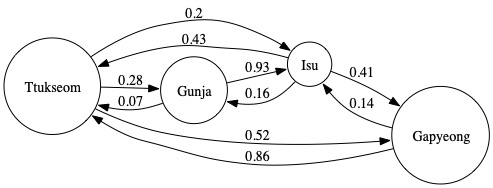

In [2]:
mc = MarkovChain(region_list=['Gunja', 'Gapyeong', 'Ttukseom', 'Isu'],
                 remove_self_flight=True,
                 generate_random_data=False,
                 csv_file_path='./data/example.csv')

base_img = mc.plot_base()
ImageDisplay(base_img)


# Determine the starting and ending region.

Specify the starting region in `start` and ending region in `end`.

This code below will generate a new transition matrix that block 
direct flight from starting region to ending region.

It will also plot the graph node that represent the transition matrix.


 BLOCKED TRANSITION MATRIX BETWEEN Gunja AND Gapyeong
          Gunja  Gapyeong  Ttukseom   Isu
Gunja      0.00      0.00      0.50  0.50
Gapyeong   0.00      0.00      0.53  0.47
Ttukseom   0.24      0.59      0.00  0.17
Isu        0.56      0.17      0.27  0.00


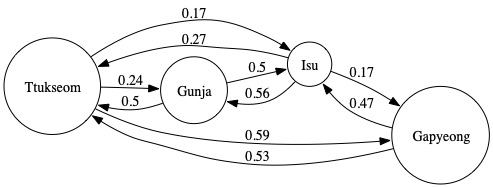

In [3]:
start = 'Gunja'
end = 'Gapyeong'
blocked_img = mc.plot_blocked_node(node_1=start,
                                   node_2=end)
ImageDisplay(blocked_img)

# Simulate

This code below will generate possible route from
the starting region into the ending region.

Tha variable `plot_mode` determine which transition matrix will be plotted:
- If set to `base`, the initial transition matrix will be plotted.
- If set to `blocked`, the blocked transition matrix between STARTING REGION and ENDING REGION will be plotted.

This code also generate several jpeg files and a gif
file that represent the simulation process.

Step: 2
Route:  ['Gunja', 'Isu', 'Gapyeong']


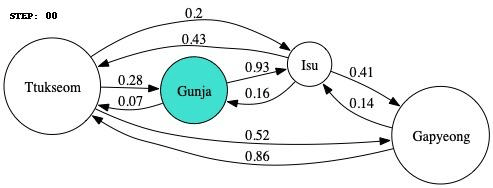

In [4]:
init_region = start
dest_region = end
plot_mode = 'base'
travel_simulated = mc.travel_simulation(init_region,
                                        dest_region,
                                        plot_mode
                                        )
print(f'Step: {len(travel_simulated)-1}')
print('Route: ',travel_simulated)

travel_img = mc.plot_travel_simulation(plot_mode)
ImageDisplay(travel_img)

# Calculate Probability ending in a region in n-step

This code below will present a graph of probability of ending in a region in n-step.

Variable `init_region` is the starting region.

Variable `final_region` is the ending region.

Variable `matrix_df` is the transition matrix that will be plotted.
There are 2 options:

- `matrix_df= mc.base_df` will plot the base transition matrix
- `matrix_df= mc.blocked_df` will plot the blocked transition matrix

Variable `n_step` is the number of steps.

Gunja Gapyeong
[0.0, 0.0, 0.4177, 0.21368800000000002, 0.3170343, 0.25242742920000005, 0.297220797268, 0.26541774802960005, 0.28803844148626323, 0.2719640612556049, 0.28338078568439484, 0.2752732838997414, 0.2810306359251346, 0.2769421847212026, 0.27984550976156697, 0.2777837749253883, 0.2792478725226941, 0.2782081744145998, 0.2789464941501938, 0.27842219192623135, 0.27879451411748607]


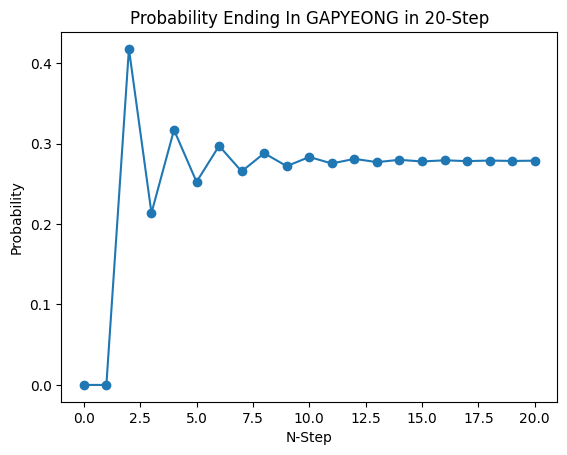

In [5]:
init_region= start
final_region= end
matrix_df= mc.base_df

print(start, end)

n_step=20
res = mc.plot_prob_ending(init_region,
                    final_region,
                    matrix_df,
                    n_step)